## 데이터 소개

### 데이터 내용
- 해당 데이터는 캐글의 [515K Hotel Reviews Data in Europe](https://www.kaggle.com/jiashenliu/515k-hotel-reviews-data-in-europe)
에서 받아왔습니다.

- 위 페이지에서 소개하기로는 Booking.com에서 스크랩 되었다고 하며, 유럽의 1493개의 럭셔리호텔들에 대한 515,000개의 리뷰를 데이터로 가지고 있습니다.

- 515,000개의 데이터 중 
Spain의 Barcelona에 있는 호텔들의 2016~2017년 데이터로만 프로젝트를 진행함

### 칼럼
- Hotel_Address: 호텔주소
- Review_Date: 리뷰한 날짜
- Average_Score: 호텔의 평균 점수(지난해 최신 코멘트를 기반으로 계산됨)
- Hotel_Name: 호텔이름
- Reviewer_Nationality: 리뷰어의 국적
- Negative_Review: 부정적 리뷰. 없을 경우 'No Negative'로 표기
- ReviewTotalNegativeWordCounts: 부정적 리뷰에 사용된 총 단어의 수
- Positive_Review: 긍정적 리뷰. 없을 경우 'No Positive'로 표기
- ReviewTotalPositiveWordCounts: 긍정적 리뷰에 사용된 총 단어의 수
- Reviewer_Score: 리뷰 점수
- TotalNumberofReviewsReviewerHasGiven: 리뷰어의 지난 리뷰들의 갯수
- TotalNumberof_Reviews: 호텔이 가진 리뷰의 수
- Tags: 리뷰어가 호텔에 단 태그
- dayssincereview: 검토 날짜와 스크래핑 날짜 사이의 기간입니다.
- AdditionalNumberof_Scoring: 투숙객들에 의한 호텔의 평가점수(리뷰를 작성하지 않은 평가자도 존재)
- lat: 호텔의 위도
- lng: 호텔의 경도

------------------------------
### 사용할 칼럼
Hotel_Address, Hotel_Name, Negative_Review, Positive_Review, Tags

### 데이터 선정이유

해당 데이터를 통해 고객들이 원하는 호텔은 추천하고자 한다.

 사용자는 호텔의 유형 즉 여행목적, 룸컨디션 등을 선택하고 자신이 찾고자 하는 호텔 혹은 가고싶지 않은 호텔의 조건을 추가적으로 기입하여 이전 리뷰에 해당 조건이 존재한다면, 제외하거나 추천하여 사용자들이 필요로 하는 호텔을 적극적으로 추천한다.

- "어떤 회사에서 높이 살 수 있을까?"
   - 해당 데이터가 '호텔'에 국한되어 있지만, 고객에게 제품을 판매하거나, 고객의 요구를 파악하여 추천하는 서비스를 제공하고자 하는 회사라면 비슷한 데이터를 가지고 있을경우 사용될 수 있을 것이라 생각한다. 


- "어디 회사의 어느부분에 적용해 볼 수 있을까"
  - "호텔예약서비스를 제공하는 회사의 호텔추천 서비스, 유통판매업의 같은 상품류 별 추천상품을 제공하는 서비스 등"


### 테이터를 이용한 가설
사람들의 리뷰를 자연어처리를 통해 모델을 학습하고,

In [2]:
# # kaggle api
# !pip install kaggle
# from google.colab import files
# files.upload()

In [3]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# # Permission Warning이 발생하지 않도록 해줍니다.
# !chmod 600 ~/.kaggle/kaggle.json

In [4]:
# ! kaggle datasets download -d jiashenliu/515k-hotel-reviews-data-in-europe

In [5]:
# !ls

In [6]:
# !unzip 515k-hotel-reviews-data-in-europe.zip

## 데이터 분석

In [7]:
# !pip install squarify

In [16]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re

from tensorflow.keras.preprocessing.text import Tokenizer

In [17]:
# 데이터 읽어와서 스페인의 16-17년 정보만 남기기
data = pd.read_csv('Hotel_Reviews.csv')
data2017_16 = data[data['Review_Date'].str.split('/').str[2] >= '2016']
spain2016_17 = data[data['Hotel_Address'].str.split().str[-1] == 'Spain']
df = spain2016_17[['Hotel_Address', 'Hotel_Name', 'Negative_Review', 'Positive_Review', 'Tags']].reset_index(drop=True)
print(f"df_shape:{df.shape}")
df.head()

df_shape:(60149, 5)


,Hotel_Address,Hotel_Name,Negative_Review,Positive_Review,Tags
0,234 Diputacio Eixample 08007 Barcelona Spain,Sansi Diputacio,First room the air conditioner wasn t working...,Restaurant across the street opens at 6am and...,"[' Leisure trip ', ' Couple ', ' Double Room '..."
1,234 Diputacio Eixample 08007 Barcelona Spain,Sansi Diputacio,No Negative,The value for money was the greatest I ve see...,"[' Leisure trip ', ' Couple ', ' Double Room '..."
2,234 Diputacio Eixample 08007 Barcelona Spain,Sansi Diputacio,Seems like the cleaning personal misunderstoo...,I like the area its close to passeig de graci...,"[' Leisure trip ', ' Family with young childre..."
3,234 Diputacio Eixample 08007 Barcelona Spain,Sansi Diputacio,Having a Pool would have been better I felt t...,Location was good as very central,"[' Leisure trip ', ' Couple ', ' Double Room '..."
4,234 Diputacio Eixample 08007 Barcelona Spain,Sansi Diputacio,to be asked to forward my booking com booking...,location smiley staff,"[' Business trip ', ' Solo traveler ', ' Doubl..."


### 전처리
- 'Hotel_Address' 피처에서 국가와 도시 분리하기
- 'Tags' 피처에서 숙박목적, 인원, 방규모 분리하기
    - 인원, 방규모는 데이터가 너무 지저분 하여 제외함
  - 특성의 전처리: 소문자화, 알파벳과 숫자 ' , '빼고 삭제
  - ' , '기준으로 구분짓고 새로운 특성으로 생성 후 기존 'Tags'삭제
- 리뷰들의 토큰화
  - 소문자화 및 불용어처리
  - 표제어추출

In [18]:
nlp = spacy.load("en_core_web_sm")
STOP_WORDS_union = nlp.Defaults.stop_words.union(['negative', 't', 'hotel', 'didn', ' '])

In [19]:
 # # 국가-도시 분리 - 스페인만 할때는 불필요함
# def split_country_city(data):
#   try:
#     data['City'] = data['Hotel_Name'].str.split(' ').str[-2]
#     data['Country'] = data['Hotel_Address'].str.split(' ').str[-1]
#     data = data.drop('Hotel_Address', axis=1)
#     data = data[['Country', 'City', 'Hotel_Name', 'Negative_Review', 'Positive_Review', 'Tags']]
#     print("split_city_country: Done!")
#   except:
#     print("split_city_country: already Done Or Not found [Hotel_Address]")
#   return data

# 같은 호텔리뷰 합쳐서 호텔들의 리뷰 리스트로 만들기
def split_hotel_review(data, review_category):
  try:
    reviews = []
    hotel_list = data['Hotel_Name'].unique()
    for i in hotel_list:
      review = ''
      hotel1 = data[data['Hotel_Name'] == i]
      for i in hotel1[review_category]:
        review = review +'. '+ i
      reviews.append(review)
    print("split_hotel_review: Done")
  except:
    print("split_hotel_review: already Done Or Not found [Hotel_Name]")
  return reviews

# ['Tags'] 전처리용 
def tags_preprocessing(data):
  for idx, text in enumerate(data):
    text = text.lower()
    text = re.sub(r"[^a-z0-9,]", '', text)
    text = text.replace('\n', ' ')
    data[idx] = text
  print('tags_preprocessing: Done!')
  return data

# 리뷰 토큰화
def get_lemmas(data):
  tokenizer = spacy.tokenizer.Tokenizer(nlp.vocab)
  tokens = []
  for doc in tokenizer.pipe(data):
    lemmas = []
    for token in doc: 
      if token.text.lower() not in STOP_WORDS_union:
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
          lemmas.append(token.lemma_.lower())
    tokens.append(lemmas)
  print("get_lemmas: Done!")
  return tokens

# 태그 분류하기
def split_Tags(data):
  count = 0
  try:
    data['travel_perpos'] = data['Tags'].str.split(',').str[0]
    # data['traveler_category'] = data['Tags'].str.split(',').str[1]
    # data['room_condition'] = data['Tags'].str.split(',').str[2]
    data = data.drop('Tags', axis=1)
    print("split_Tags: Done, Without Submitted_from_mobiledevice!")
  except:
    print("split_Tags: already Done Or Not found [Tags]")
  return data

In [20]:
# df = split_city_country(df)
df['Tags'] = tags_preprocessing(df['Tags'])
df = split_Tags(df)

Negative_Review = split_hotel_review(df, 'Negative_Review')
Positive_Review = split_hotel_review(df, 'Positive_Review')

df['Negative_Review'] = get_lemmas(df['Negative_Review'])
df['Positive_Review'] = get_lemmas(df['Positive_Review'])

tags_preprocessing: Done!
split_Tags: Done, Without Submitted_from_mobiledevice!
split_hotel_review: Done
split_hotel_review: Done
get_lemmas: Done!
get_lemmas: Done!


In [21]:
from collections import Counter
def word_count(docs):
    """ 토큰화된 문서들을 입력받아 토큰을 카운트 하고 관련된 속성을 가진 데이터프레임을 리턴합니다.
    Args:
        docs (series or list): 토큰화된 문서가 들어있는 list
    Returns:
        list: Dataframe
    """
    # 전체 코퍼스에서 단어 빈도 카운트
    word_counts = Counter()

    # 단어가 존재하는 문서의 빈도 카운트, 단어가 한 번 이상 존재하면 +1
    word_in_docs = Counter()

    # 전체 문서의 갯수
    total_docs = len(docs)

    for doc in docs:
        word_counts.update(doc)
        word_in_docs.update(set(doc))

    temp = zip(word_counts.keys(), word_counts.values())

    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    # 단어의 순위
    # method='first': 같은 값의 경우 먼저나온 요소를 우선
    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()

    # 코퍼스 내 단어의 비율
    wc['percent'] = wc['count'].apply(lambda x: x / total)

    wc = wc.sort_values(by='rank')

    # 누적 비율
    # cumsum() : cumulative sum
    wc['cul_percent'] = wc['percent'].cumsum()

    temp2 = zip(word_in_docs.keys(), word_in_docs.values())
    ac = pd.DataFrame(temp2, columns=['word', 'word_in_docs'])
    wc = ac.merge(wc, on='word')
    
    # 전체 문서 중 존재하는 비율
    wc['word_in_docs_percent'] = wc['word_in_docs'].apply(lambda x: x / total_docs)

    return wc.sort_values(by='rank')

Negative_Review_word_top10


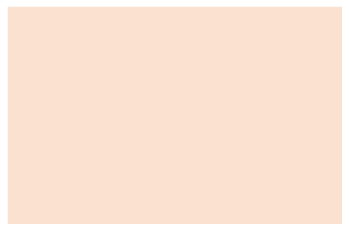

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
0,,40986,453876,1.0,1.0,1.0,0.681408


In [24]:
import squarify
Negative_Review_wc = word_count(df['Negative_Review'])
Negative_Review_wc_top10 = Negative_Review_wc[Negative_Review_wc['rank'] <= 10]
print("Negative_Review_word_top10")
squarify.plot(sizes=Negative_Review_wc_top10['percent'], label=Negative_Review_wc_top10['word'], alpha=0.6 )
plt.axis('off')
plt.show()
Negative_Review_wc_top10

Positive_Review_word_top10


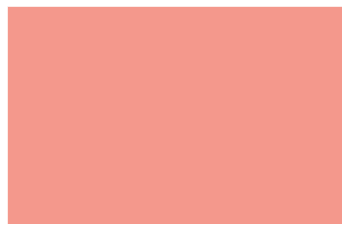

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
0,,59498,582961,1.0,1.0,1.0,0.989177


In [25]:
Positive_Review_wc = word_count(df['Positive_Review'])
Positive_Review_wc_top10 = Positive_Review_wc[Positive_Review_wc['rank'] <= 10]
print("Positive_Review_word_top10")
squarify.plot(sizes=Positive_Review_wc_top10['percent'], label=Positive_Review_wc_top10['word'], alpha=0.6 )
plt.axis('off')
plt.show()
Positive_Review_wc_top10

### 리뷰 벡터화(TF-IDF)

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [27]:
# plot 스타일과 폰트 크기를 설정합니다.
sns.set(style='whitegrid', font_scale=1.15)

# 문서별 단어의 수 분포도 그리는 함수
def plot_text_length_dist(text_list):

    # 문장이 요소인 리스트를 받아 각 문서의 단어 수를 가진 리스트를 만듭니다
    num_words = [len(doc.split()) for doc in text_list]
    
    sns.displot(num_words)
    plt.title('# of words per documents')
    plt.xlabel('Number of words')
    plt.ylabel('Number of documents')
    plt.show()

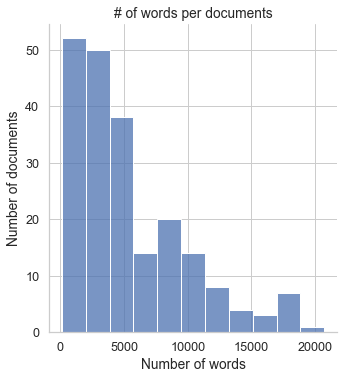

In [28]:
plot_text_length_dist(Positive_Review)

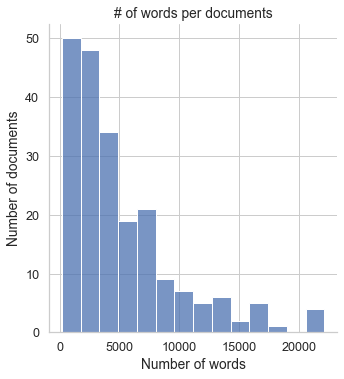

In [29]:
plot_text_length_dist(Negative_Review)

In [30]:
# spacy tokenizer 함수
def tokenize(document):
    
    doc = nlp(document)
    # punctuations: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
    return [token.lemma_.strip() for token in doc if (token.is_stop != True) and (token.is_punct != True) and (token.is_alpha == True)]

In [31]:
import warnings
warnings.filterwarnings("ignore")

In [32]:
# NearestNeighbor (K-NN, K-최근접 이웃)
N_tfidf = TfidfVectorizer(stop_words='english'
                        ,tokenizer=tokenize
                        ,ngram_range=(1,2)
                        ,max_df=.7
                        ,min_df=3
                        ,max_features = 20000
                       )
P_tfidf = TfidfVectorizer(stop_words='english'
                        ,tokenizer=tokenize
                        ,ngram_range=(1,2)
                        ,max_df=.7
                        ,min_df=3
                        ,max_features = 20000
                       )
Negative_Review_dtm = N_tfidf.fit_transform(Negative_Review)
Negative_Review_dtm = pd.DataFrame(Negative_Review_dtm.todense(), columns=N_tfidf.get_feature_names())
print(Negative_Review_dtm.head())

Positive_Review_dtm = P_tfidf.fit_transform(Positive_Review)
Positive_Review_dtm = pd.DataFrame(Positive_Review_dtm.todense(), columns=P_tfidf.get_feature_names())
print(Positive_Review_dtm.head())

    ab  abandon  ability  abit      able  able access  able change  \
0  0.0      0.0      0.0   0.0  0.000000          0.0          0.0   
1  0.0      0.0      0.0   0.0  0.020229          0.0          0.0   
2  0.0      0.0      0.0   0.0  0.015139          0.0          0.0   
3  0.0      0.0      0.0   0.0  0.000000          0.0          0.0   
4  0.0      0.0      0.0   0.0  0.008793          0.0          0.0   

   able check  able close  able coffee  ...  young people  youngster  youth  \
0         0.0         0.0          0.0  ...           0.0        0.0    0.0   
1         0.0         0.0          0.0  ...           0.0        0.0    0.0   
2         0.0         0.0          0.0  ...           0.0        0.0    0.0   
3         0.0         0.0          0.0  ...           0.0        0.0    0.0   
4         0.0         0.0          0.0  ...           0.0        0.0    0.0   

    yr  yuk    z      zero  zero sound  zip      zone  
0  0.0  0.0  0.0  0.000000         0.0  0.0  0.0

### 유사도를 이용한 문서검색(NearestNeighbor (K-NN, K-최근접 이웃))

In [33]:
from sklearn.neighbors import NearestNeighbors

# dtm을 사용히 NN 모델을 학습시킵니다. (디폴트)최근접 5 이웃.
Negative_Review_nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
Negative_Review_nn.fit(Negative_Review_dtm)

Positive_Review_nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
Positive_Review_nn.fit(Positive_Review_dtm)

NearestNeighbors(algorithm='kd_tree')

In [34]:
Negative_Review_nn.kneighbors([Negative_Review_dtm.iloc[0].values])

(array([[0.        , 1.29045742, 1.29911656, 1.30106376, 1.30255274]]),
 array([[  0,  80,  20,  31, 146]]))

In [35]:
Positive_Review_nn.kneighbors([Positive_Review_dtm.iloc[0].values])

(array([[0.        , 1.32190539, 1.32801265, 1.33103839, 1.33420492]]),
 array([[  0, 101,  41,  68,  40]]))

기능추가

In [36]:
# ['travel_perpos']을 통해서 해당 유형에서 가장 많이 예약된 상위 5개의 호텔 알려주기
def top5_hotel_by_travel_perpos(data, travel_perpos):
  travel_perpos_ls = data['travel_perpos'].unique()
  hotel_list = data['Hotel_Name'].unique()
  dic = {}
  for i in hotel_list:
    s = data[data['Hotel_Name']==i]['travel_perpos']=='travel_perpos'
    dic[i]=s.count()
  top5 = sorted(dic.items(), key=lambda x: x[1], reverse=True)[0:5]
  print(f"입력된 숙박목적은 '{travel_perpos}'이며, 해당 목적으로 가장많이 이용된 상위5개 호텔과 이용자 수 는 다음과 같습니다. ")
  return top5

# 사용자의 추가적인 조건에 따라 호텔 추천하기
def kneighbors(Negative, Positive):
  hotel_list = data['Hotel_Name'].unique()
  test_N = N_tfidf.transform(Negative)
  test_P = P_tfidf.transform(Positive)
  Negative_kneighbors=Negative_Review_nn.kneighbors(test_N.todense())[1][0]
  Positive_kneighbors=Positive_Review_nn.kneighbors(test_P.todense())[1][0]
  print(f"입력된 싫어하는 호텔조건은\n {Negative}\n이며, 입력된 조건과 비슷한 리뷰가 있는 호텔은 다음과 같습니다.")
  for i in hotel_list[Negative_kneighbors]:
    print(i)
  print("\n")
  print(f"입력된 선호하는 호텔조건은\n {Positive}\n이며, 입력된 조건과 비슷한 리뷰가 있는 호텔은 다음과 같습니다.")
  for i in hotel_list[Positive_kneighbors]:
    print(i)
  return

## 결과 알려주기
- ['travel_perpos']을 통해서 해당 유형에서 숙박리뷰가 가장 많은 호텔 알려주기
- 싫어하는 호텔조건을 통해 비슷한 네거티브리뷰가 있는 호텔 알려주
- 좋아하는 호텔조건을 통해 비슷한 포지티브리뷰가 있는 호텔 알려주기

In [37]:
# ['travel_perpos']의 종류
travel_perpos = ['leisuretrip', 'businesstrip', 'couple', 'solotraveler',
       'familywithyoungchildren', 'withapet', 'group',
       'travelerswithfriends', 'familywitholderchildren']

In [38]:
# 'n1'=[""".  Breakfast should be better is not 4 star hotel level Music in the hallway was too loud and annoying No possibility of opening the room window .  The staff was unacceptable Especially Aylin We were precharged for parking and by the time we arrived they said they no longer have a parking place so they sent us to another one for which we also paid 61 50 The problem is we still didn t get our 72 60 that we had prepaid And it s been 2 weeks since our stay Aslo a week before our stay they had sent us an e mail telling us that there had been something wrong with the payment but the bank said they had already got the money weeks ago Nothing like that has ever happened to me before and I am traveling a lot They still haven t paid me back for the parking they don t even have Barcelona is amazing Just choose another hotel .  Not sure how this is a 4 star hotel No coffee machine No safety box Check in took 20 minutes No isolation between bathroom and room Your kid will wake up if you take a shower.  it s not a bad experience but if you choose this hotel for your holiday inform them that you want a room with city view Our room had a view of air well and it was lack of sunshine I asked them to change the room but the hotel was full at that time .  AIR CONDITIONING WAS NOT GOOD AND STUFF HAD NO SOLUTION FOR IT THE LIFT IS OLD WHEN IN USE STRANGE NOISES WERE COMING.  I have seen two stars hotels with better facilities then this four stars hotel Anyway good value for money considering the location . No Negative. No Negative. No Negative.  They like to copy creditcard. No Negative.  One negative noisy cleaners very early in the morning due to thin walls . No Negative.  There is some one of the housekepers take my watch when he cleaned my room.  bathroom needs to be refurbished"""],
# 'p1'=[""".  Staff is nice and always smiling Ideal position .  location.  Location is nice .  Debonair staff trying to help you all the time clean non smoking rooms good breakfast good location .  GOOD LOCATION NICE AMBIANCE HELPFUL STAFF AT LEAST TRIED THERE BEST .  Good location reasonably priced .  Value for stay close to La Ramblas Staff assist and hospitality.  Staff was very serviceminded.  Staff were excellent polite and accommodating Location was excellent . No Positive.  Extremly helpful and friendly staff Ideally situated .  Great location Modern decor Good value for money .  Location just walking distance to Rambla St.  The resiption staff location.  everything else was quite good"""]

In [ ]:
user1 = {
    'travel_perpos':str(input("travel_perpos?:")),
    'n1':[input("negative_r?: ")],
    'p1':[input("positive_r?: ")]
    }

In [40]:
top5_hotel_by_travel_perpos(df, user1['travel_perpos'])

입력된 숙박목적은 'businesstrip'이며, 해당 목적으로 가장많이 이용된 상위5개 호텔과 이용자 수 는 다음과 같습니다. 


[('Eurostars Grand Marina Hotel GL', 1082),
 ('Catalonia Atenas', 1061),
 ('Catalonia Plaza Catalunya', 964),
 ('Catalonia Barcelona Plaza', 932),
 ('Barcelona Princess', 897)]

In [41]:
kneighbors(user1['n1'], user1['p1'])

입력된 싫어하는 호텔조건은
 ['Breakfast should be better is not 4 star hotel level Music in the hallway was too loud and annoying No possibility of opening the room window .  The staff was unacceptable Especially Aylin We were precharged for parking and by the time we arrived they said they no longer have a parking place so they sent us to another one for which we also paid 61 50 The problem is we still didn t get our 72 60 that we had prepaid And it s been 2 weeks since our stay Aslo a week before our stay they had sent us an e mail telling us that there had been something wrong with the payment but the bank said they had already got the money weeks ago Nothing like that has ever happened to me before and I am traveling a lot They still haven t paid me back for the parking they don t even have Barcelona is amazing Just choose another hotel .  Not sure how this is a 4 star hotel No coffee machine No safety box Check in took 20 minutes No isolation between bathroom and room Your kid will wake up if